# Definiciones

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from deap import base, creator, tools, algorithms
from pyproj import Proj
from geopy.distance import geodesic

# Definir las coordenadas de las ciudades
cities = {
    "Seattle": (47.608013, -122.335167),
    "Boise": (43.616616, -116.200886),
    "Everett": (47.967306, -122.201399),
    "Pendleton": (45.672075, -118.788597),
    "Biggs": (45.669846, -120.832841),
    "Portland": (45.520247, -122.674194),
    "Twin Falls": (42.570446, -114.460255),
    "Bend": (44.058173, -121.315310),
    "Spokane": (47.657193, -117.423510),
    "Grant Pass": (42.441561, -123.339336),
    "Burns": (43.586126, -119.054413),
    "Eugene": (44.050505, -123.095051),
    "Lakeview": (42.188772, -120.345792),
    "Missoula": (46.870105, -113.995267)
}

# Proyección cartográfica
projection = Proj(proj='aeqd', ellps='WGS84', datum='WGS84', lat_0=0, lon_0=0)

def project_coordinates(lon, lat):
    x, y = projection(lon, lat)
    return x, y

# Proyectar las coordenadas de las ciudades
projected_cities = {city: project_coordinates(lon, lat) for city, (lat, lon) in cities.items()}

# Función de Fitness y Configuraión del Algoritmo Genético

In [2]:
# Convertir índices a nombres de ciudades
def indices_to_cities(indices):
    return [list(cities.keys())[i] for i in indices]

def calculate_total_distance(indices):
    route = indices_to_cities(indices)
    total_distance = 0
    for i in range(len(route)):
        city_a = route[i]
        city_b = route[(i + 1) % len(route)]
        total_distance += geodesic(cities[city_a], cities[city_b]).kilometers
    return total_distance,


# Crear el objeto fitness y los individuos
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


toolbox = base.Toolbox()

# Función para crear una ruta aleatoria
toolbox.register("indices", random.sample, range(len(cities)), len(cities))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Función de fitness
toolbox.register("evaluate", calculate_total_distance)

# Operadores genéticos
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(cities))

# Algoritmo Genético

In [3]:
# Hall of Fame para la versión sin elitismo
hof_no_elitism = tools.HallOfFame(5)

# Estadísticas
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)

# Función para imprimir la información de cada generación
def print_generation_info(generation, population):
    best_ind = tools.selBest(population, 1)[0]
    print(f"**GENERATION**: {generation}")
    print("******************")
    if generation == 0:
        print("INITIAL RANDOM PATH AND DISTANCE:")
    else:
        print("PATH AND DISTANCE:")
    route = indices_to_cities(best_ind)
    print(" ==> ".join(route) + " ==> " + route[0])
    print(f"Fitness value: {best_ind.fitness.values[0]}")
    print("******************")

# Inicializa la población
random.seed(42)
population_no_elitism = toolbox.population(n=300)

# Inicializa listas para almacenar datos de fitness
min_fitness_values = []
avg_fitness_values = []
generations = range(200)

# Algoritmo genético sin elitismo
for gen in generations:
    # Genera una nueva generación de descendientes
    offspring = algorithms.varAnd(population_no_elitism, toolbox, cxpb=0.90, mutpb=0.1)
    
    # Evalúa a los individuos con un fitness inválido
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Actualiza la población seleccionando los mejores individuos
    population_no_elitism = toolbox.select(offspring, len(population_no_elitism))

    # Actualiza el Hall of Fame
    hof_no_elitism.update(population_no_elitism)

    # Imprime la información de la generación
    print_generation_info(gen, population_no_elitism)

    # Recolecta estadísticas
    record = stats.compile(population_no_elitism)
    print(record)

    # Recolecta y almacena los datos de fitness
    min_fitness_values.append(record['min'])
    avg_fitness_values.append(record['avg'])


**GENERATION**: 0
******************
INITIAL RANDOM PATH AND DISTANCE:
Seattle ==> Portland ==> Missoula ==> Twin Falls ==> Boise ==> Biggs ==> Bend ==> Grant Pass ==> Eugene ==> Lakeview ==> Burns ==> Spokane ==> Pendleton ==> Everett ==> Seattle
Fitness value: 4233.192286079306
******************
{'avg': 5701.494186193562, 'min': 4233.192286079306}
**GENERATION**: 1
******************
PATH AND DISTANCE:
Everett ==> Seattle ==> Pendleton ==> Burns ==> Bend ==> Grant Pass ==> Twin Falls ==> Boise ==> Lakeview ==> Eugene ==> Portland ==> Biggs ==> Missoula ==> Spokane ==> Everett
Fitness value: 4132.4389231362875
******************
{'avg': 5506.4858026644915, 'min': 4132.4389231362875}
**GENERATION**: 2
******************
PATH AND DISTANCE:
Pendleton ==> Bend ==> Burns ==> Grant Pass ==> Twin Falls ==> Boise ==> Lakeview ==> Eugene ==> Portland ==> Biggs ==> Missoula ==> Spokane ==> Everett ==> Seattle ==> Pendleton
Fitness value: 4296.302524670289
******************
{'avg': 5408.098964

In [4]:
# Hall of Fame para la versión con elitismo
hof_elitism = tools.HallOfFame(30)

# Estadísticas
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)

# Función para imprimir la información de cada generación
def print_generation_info(generation, population):
    best_ind = tools.selBest(population, 1)[0]
    print(f"**GENERATION**: {generation}")
    print("******************")
    if generation == 0:
        print("INITIAL RANDOM PATH AND DISTANCE:")
    else:
        print("PATH AND DISTANCE:")
    route = indices_to_cities(best_ind)
    print(" ==> ".join(route) + " ==> " + route[0])
    print(f"Fitness value: {best_ind.fitness.values[0]}")
    print("******************")

# Inicializa la población
random.seed(42)
population_elitism = toolbox.population(n=300)

# Número de individuos a mantener en cada generación (elitismo)
num_elites = 10

# Inicializa listas para almacenar datos de fitness
min_fitness_values_elitism = []
avg_fitness_values_elitism = []
generations_elitism = range(200)

# Algoritmo genético con elitismo
for gen in range(200):
    # Genera una nueva generación de descendientes
    offspring = algorithms.varAnd(population_elitism, toolbox, cxpb=0.90, mutpb=0.1)
    
    # Evalúa a los individuos con un fitness inválido
    for ind in offspring:
        if not ind.fitness.valid:
            ind.fitness.values = toolbox.evaluate(ind)

    # Elitismo: Selecciona los mejores individuos y los agrega a la nueva generación
    elites = tools.selBest(population_elitism, num_elites)
    offspring = toolbox.select(offspring, len(population_elitism) - num_elites)
    offspring.extend(elites)

    # Evalúa a todos los individuos en la nueva población
    for ind in offspring:
        ind.fitness.values = toolbox.evaluate(ind)

    # Actualiza la población
    population_elitism = offspring

    # Actualiza el Hall of Fame
    hof_elitism.update(population_elitism)

    # Imprime la información de la generación
    print_generation_info(gen, population_elitism)

    # Recolecta estadísticas
    record_elitism = stats.compile(population_elitism)
    print(record_elitism)

    # Recolecta y almacena los datos de fitness
    min_fitness_values_elitism.append(record_elitism['min'])
    avg_fitness_values_elitism.append(record_elitism['avg'])

**GENERATION**: 0
******************
INITIAL RANDOM PATH AND DISTANCE:
Seattle ==> Portland ==> Missoula ==> Twin Falls ==> Boise ==> Biggs ==> Bend ==> Grant Pass ==> Eugene ==> Lakeview ==> Burns ==> Spokane ==> Pendleton ==> Everett ==> Seattle
Fitness value: 4233.192286079306
******************
{'avg': 5701.717368274436, 'min': 4233.192286079306}
**GENERATION**: 1
******************
PATH AND DISTANCE:
Portland ==> Missoula ==> Twin Falls ==> Boise ==> Bend ==> Grant Pass ==> Eugene ==> Lakeview ==> Burns ==> Spokane ==> Pendleton ==> Biggs ==> Seattle ==> Everett ==> Portland
Fitness value: 4111.679534125871
******************
{'avg': 5469.577162833949, 'min': 4111.679534125871}
**GENERATION**: 2
******************
PATH AND DISTANCE:
Portland ==> Missoula ==> Twin Falls ==> Boise ==> Bend ==> Grant Pass ==> Eugene ==> Lakeview ==> Burns ==> Spokane ==> Pendleton ==> Biggs ==> Seattle ==> Everett ==> Portland
Fitness value: 4111.679534125871
******************
{'avg': 5313.962777231

# Visualización - Rutas

In [5]:
def plot_route(route, title):
    # Convierte la ruta a coordenadas proyectadas
    route_coords = [projected_cities[city] for city in route]
    route_coords.append(route_coords[0])  # Regresar a la ciudad inicial

    # Desempaqueta las coordenadas
    x, y = zip(*route_coords)

    # Configura el gráfico
    plt.figure(figsize=(10, 8))
    plt.plot(x, y, 'o-', mfc='r')
    #plt.gca().invert_xaxis()  # Invertir el eje X
    plt.title(title)

    # Etiqueta cada ciudad en el gráfico
    for city, (xi, yi) in projected_cities.items():
        plt.text(xi, yi, city)

    plt.show()

## Mejor Ruta de la Población y de Todas las Generaciones

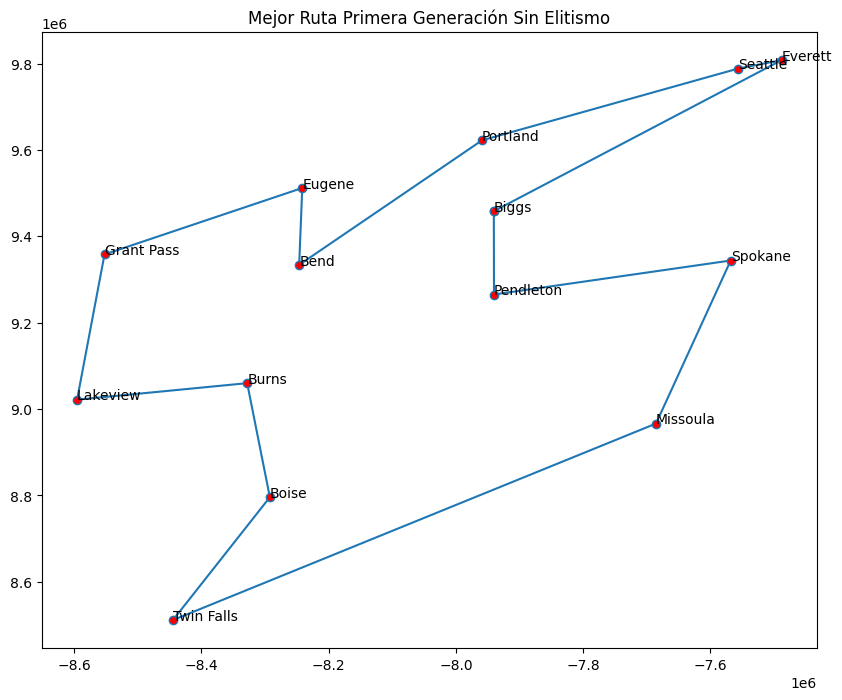

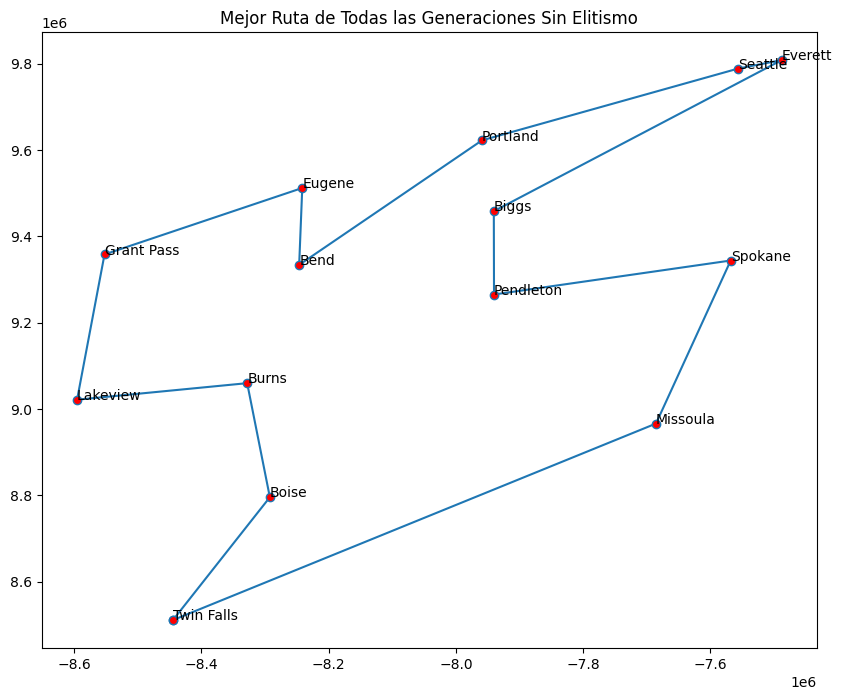

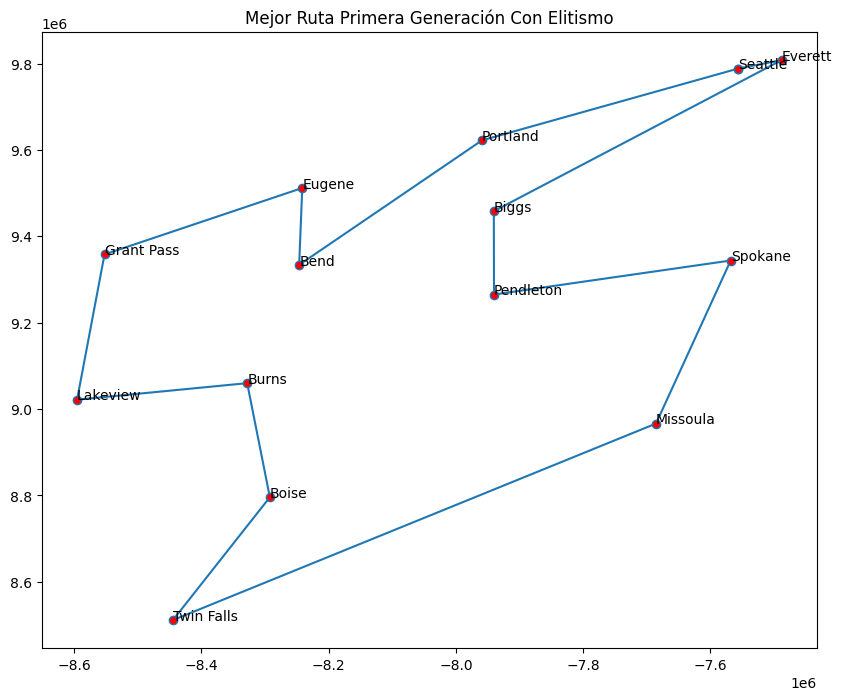

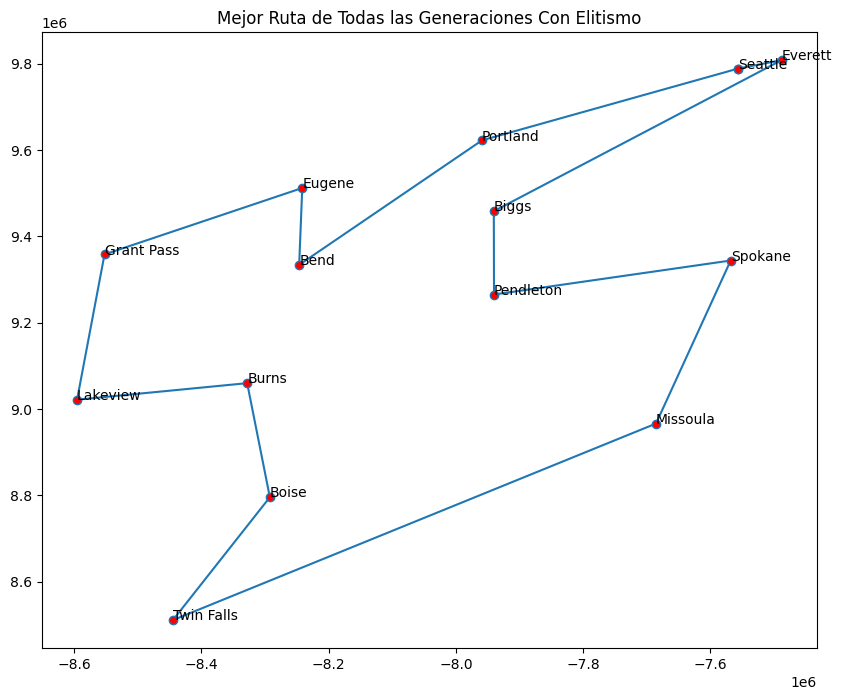

In [6]:
# Visualizar la mejor ruta de la primera generación sin elitismo
best_route_first_generation_no_elitism = indices_to_cities(tools.selBest(population_no_elitism, 1)[0])
plot_route(best_route_first_generation_no_elitism, "Mejor Ruta Primera Generación Sin Elitismo")

# Visualizar la mejor ruta de todas las generaciones sin elitismo
best_route_all_generations_no_elitism = indices_to_cities(hof_no_elitism[0])
plot_route(best_route_all_generations_no_elitism, "Mejor Ruta de Todas las Generaciones Sin Elitismo")

# Visualizar la mejor ruta de la primera generación con elitismo
best_route_first_generation_elitism = indices_to_cities(tools.selBest(population_elitism, 1)[0])
plot_route(best_route_first_generation_elitism, "Mejor Ruta Primera Generación Con Elitismo")

# Visualizar la mejor ruta de todas las generaciones con elitismo
best_route_all_generations_elitism = indices_to_cities(hof_elitism[0])
plot_route(best_route_all_generations_elitism, "Mejor Ruta de Todas las Generaciones Con Elitismo")

# Visualizacion del Progreso del Fitness

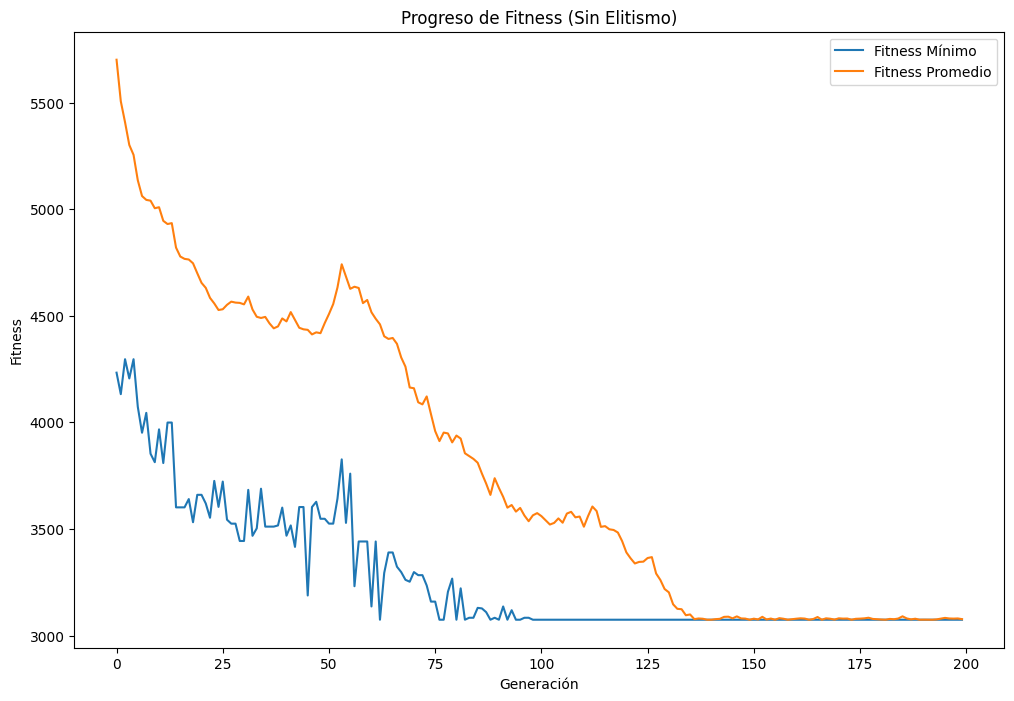

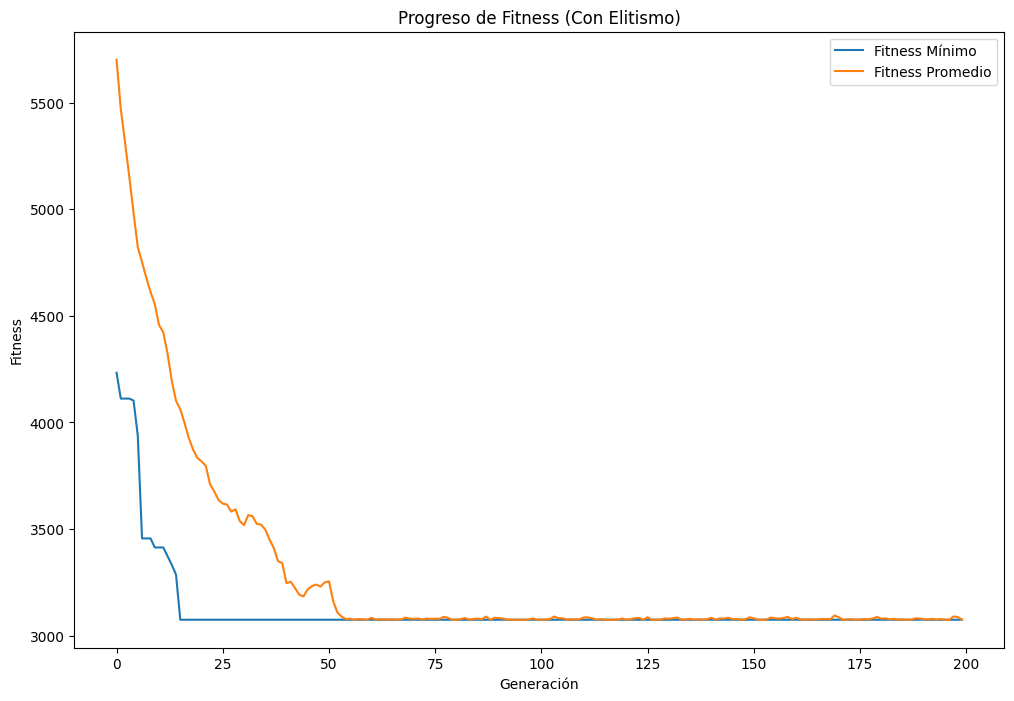

In [12]:
def plot_fitness(generations, min_fitness, avg_fitness, title):
    plt.figure(figsize=(12, 8))
    plt.plot(generations, min_fitness, label="Fitness Mínimo")
    plt.plot(generations, avg_fitness, label="Fitness Promedio")
    plt.title(title)
    plt.xlabel("Generación")
    plt.ylabel("Fitness")
    plt.legend()
    plt.show()

# Gráfico de progreso de fitness (sin elitismo)
plot_fitness(generations, min_fitness_values, avg_fitness_values, "Progreso de Fitness (Sin Elitismo)")

# Gráfico de progreso de fitness (con elitismo)
plot_fitness(generations_elitism, min_fitness_values_elitism, avg_fitness_values_elitism, "Progreso de Fitness (Con Elitismo)")